In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os
import copy
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn

In [5]:
# now the import from the pytorch disco library
from nets.quant_policy_metric_models import EmbeddingGenerator
from backend.quant_metric_inputs import MetricLearningData

os.environ mode is MUJOCO_OFFLINE
train_metric_learner
  mujoco_offline
    do_mujoco_offline = True
  mujoco_offline_data
    dataset_name = "mujoco_offline"
    H = 128
    W = 128
    trainset = "all_cups_data_and_bottles_data_with_bbox"
    dataset_location = "/projects/katefgroup/shared_quant_models/data_with_bbox"
    dataset_list_dir = "/projects/katefgroup/shared_quant_models/data_with_bbox"
    dataset_format = "txt"
  40k_iters
    max_iters = 40000
  B1
    B = 1
  MB2
    MB = 2
  lr3
    lr = 1e-3
  frozen_feat
    do_feat = True
    do_freeze_feat = True
    feat_dim = 32
  frozen_occ
    do_occ = True
    do_freeze_occ = True
    occ_coeff = 1.0
    occ_do_cheap = True
    occ_smooth_coeff = 1.0
  frozen_view
    do_view = True
    do_freeze_view = True
    view_depth = 32
    view_pred_embs = True
    view_l1_coeff = 1.0
  eval_recall
    do_eval_recall = True
    feat_init = "/projects/katefgroup/shared_quant_models/02_m64x64x64_p64x64_1e-3_F32_Oc_c1_s1_Ve_d32_c1_all_c

In [7]:
# dataset tester cell
metric_dataset = MetricLearningData(
    '/projects/katefgroup/shared_quant_models/train_extracted_obj_tensors',
    transforms=None)
data_dict = metric_dataset[0]
print('--- USING THE BACKEND INPUT LOADER ---')
print(data_dict['tensor'].shape)
print(data_dict['label'])

--- USING THE BACKEND INPUT LOADER ---
(32, 32, 32, 32)
1


In [8]:
# Hyperparams file goes here, Need to make chnages so that I load from the file and file should
# have a unique name based on the git commit id:

BATCH_SIZE = 32
NUM_EPOCHS = 200
LR = 1e-4
TEMPERATURE = 0.7
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOG_INTERVAL = 5
SAVE_INTERVAL = 50
SAVE_DIR = "/projects/katefgroup/shared_quant_models/temp_train_delete_soom"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [10]:
# wrap the dataset in dataloader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=metric_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [13]:
# generate the validation dataset
print('--- Making the Validation data ----')
metric_dataset1 = MetricLearningData('/projects/katefgroup/shared_quant_models/val_extracted_object_tensors',
                                     transforms=None)
val_dataloader = DataLoader(dataset=metric_dataset1, batch_size=1, shuffle=True, drop_last=False)
print(metric_dataset1[1]['tensor'].shape)
print(metric_dataset[1]['label'])

--- Making the Validation data ----
(32, 32, 32, 32)
0


In [15]:
# cup labels is zero and bottle labels is 1
# the loss function cell
# it works as follows
# first the cup and the bottle embeddings are separated
# then for each cup the next cup in sequence forms its positive pair
# for each bottle next bottle in the sequence forms its positive pair
# for each cup all the bottles form the negatives and vice versa
# K-way classification loss is computed using binary cross entropy

def compute_loss(embeddings, labels, device):
    B, C = list(embeddings.shape)

    cup_idxs = (labels == 0).nonzero()
    cup_embeddings = embeddings[cup_idxs.squeeze(1)]
    
    # check the dimensions:
    assert cup_embeddings.ndim == 2
    assert cup_embeddings.shape[1] == C

    bottle_idxs = (labels == 1).nonzero()
    bottle_embeddings = embeddings[bottle_idxs.squeeze(1)]
    
    # check the dimensions
    assert bottle_embeddings.ndim == 2
    assert bottle_embeddings.shape[1] == C

    # generate the positives for the cup, strategy is for 0, 1 serves as positive and so on
    # finally for the last entry the zeroth entry serves as the positive
    positive_cup_embeddings = cup_embeddings[1:,:].clone()
    positive_cup_embeddings = torch.cat((positive_cup_embeddings, cup_embeddings[0][None].clone()))
    
    # check the dimensions
    assert cup_embeddings.shape == positive_cup_embeddings.shape

    # generate positives for the bottle, strategy is same as that for the cup
    positive_bottle_embeddings = bottle_embeddings[1:,:].clone()
    positive_bottle_embeddings = torch.cat((positive_bottle_embeddings, bottle_embeddings[0][None].clone()))
    
    # check the dimensions
    assert bottle_embeddings.shape == positive_bottle_embeddings.shape

    # check that the order of the positives is one after the another.
    assert torch.equal(positive_cup_embeddings[:-1, :], cup_embeddings[1:, :])
    assert torch.equal(positive_bottle_embeddings[:-1, :], bottle_embeddings[1:, :])
    assert torch.equal(positive_cup_embeddings[-1], cup_embeddings[0])
    assert torch.equal(positive_bottle_embeddings[-1], bottle_embeddings[0])

    # collate the positives together to compute the positive loss
    pos_query_embeddings = torch.cat((cup_embeddings, bottle_embeddings))
    assert len(pos_query_embeddings) == B
    pos_key_embeddings = torch.cat((positive_cup_embeddings, positive_bottle_embeddings))
    assert len(pos_key_embeddings) == B

    # again checking that concat has not screwed up anything
    assert torch.equal(pos_query_embeddings[1:len(cup_embeddings)], pos_key_embeddings[0:len(cup_embeddings)-1])
    assert pos_query_embeddings.shape == pos_key_embeddings.shape

    # now bring the positives closer, well here just compute the dot product
    l_pos = torch.bmm(pos_query_embeddings.view(B, 1, C), pos_key_embeddings.view(B, C, 1))
    l_pos = l_pos.view(-1, 1)

    # now make the negatives far apart, means the dot product of this should go close to zero
    # for each cup every bottle is negative and for each bottle every cup is negative.
    # ASHWINI: I am keeping the min as the negatives, so it will change in each batch would that be a problem?
    num_neg_samples = min(len(cup_embeddings), len(bottle_embeddings))

    # negs for cups, cups are N,C and bottles we would want C, K=min_num assuming bottles are more
    l_negs_cup = torch.mm(cup_embeddings, bottle_embeddings[:num_neg_samples, :].view(C, num_neg_samples))
    l_negs_bottle = torch.mm(bottle_embeddings, cup_embeddings[:num_neg_samples, :].view(C, num_neg_samples))
    l_negs = torch.cat((l_negs_cup, l_negs_bottle), dim=0)
    
    # finally compute the loss and be done with it
    logits = torch.cat((l_pos, l_negs), dim=1)

    # labels, positives are the zero-th 
    labels = torch.zeros(len(logits)).long().to(device)

    # compute the cross entropy loss
    loss = F.cross_entropy(logits/TEMPERATURE, labels)
    return loss

In [16]:
# for one epoch see if you can load it properly

def train(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    total_loss = 0.0
    iter_cnt = 0
    for i, data_dict in enumerate(train_loader):
        ob_tensors = data_dict['tensor'].to(device)
        ob_labels = data_dict['label'].to(device).long()
        # do the forward pass through the model
        output = model(ob_tensors)
        # compute the loss
        loss = loss_fn(output, ob_labels, device=device)
        # do the optimization
        p_before = [copy.deepcopy(p) for p in model.parameters()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # TODO: check that the weights are indeed changing
        p_after = [copy.deepcopy(p) for p in model.parameters()]
        truth_val = [torch.equal(a, b) for a, b in zip(p_before, p_after)]
        # we want the values to change so all the truth_values should be false
        assert not all(truth_val), "some weights are not changing"
        
        total_loss += loss.cpu().item()
        iter_cnt += 1
    
    avg_loss = total_loss / float(iter_cnt)
    return avg_loss

In [17]:
# training of the model Cell
metric_model = EmbeddingGenerator(emb_dim=128).to(DEVICE)
optimizer = torch.optim.Adam(metric_model.parameters(), lr=LR)
loss_fn = compute_loss

down dims:  [32, 64, 128]


Epoch: 0	 loss: 1.4589979648590088
Epoch: 1	 loss: 1.2623309691747029
Epoch: 2	 loss: 1.0758578578631084
Epoch: 3	 loss: 0.9346092939376831
Epoch: 4	 loss: 0.8170311450958252
Epoch: 5	 loss: 0.6604413390159607
Epoch: 6	 loss: 0.515629400809606
Epoch: 7	 loss: 0.5266870657602946
Epoch: 8	 loss: 0.4766545593738556
Epoch: 9	 loss: 0.4993932247161865
Epoch: 10	 loss: 0.4990302821000417
Epoch: 11	 loss: 0.4670935968557994
Epoch: 12	 loss: 0.4944561719894409
Epoch: 13	 loss: 0.4320493241151174
Epoch: 14	 loss: 0.4884066383043925
Epoch: 15	 loss: 0.48991366227467853
Epoch: 16	 loss: 0.49800366163253784
Epoch: 17	 loss: 0.4904164969921112
Epoch: 18	 loss: 0.4871133863925934
Epoch: 19	 loss: 0.5124364991982778
Epoch: 20	 loss: 0.4783419072628021
Epoch: 21	 loss: 0.4991835157076518
Epoch: 22	 loss: 0.5105776389439901
Epoch: 23	 loss: 0.4686138530572255
Epoch: 24	 loss: 0.4990033109982808
Epoch: 25	 loss: 0.5169607798258463
Epoch: 26	 loss: 0.4782590866088867
Epoch: 27	 loss: 0.4700857599576314
E

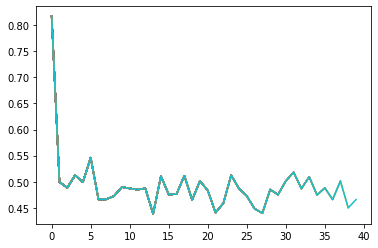

In [18]:
ep_loss_collect = []
for ep in range(NUM_EPOCHS):
    ep_loss = train(metric_model,
                    device=DEVICE,
                    train_loader=train_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epoch=ep)
    print(f'Epoch: {ep}\t loss: {ep_loss}')
    if (ep+1) % LOG_INTERVAL == 0:
        # plot the loss function
        ep_loss_collect.append(ep_loss)
        plt.plot(range(len(ep_loss_collect)), ep_loss_collect)
    
    if (ep+1) % SAVE_INTERVAL == 0:
        # save the model
        save_path = f'{SAVE_DIR}/model_{ep+1}.pth'
        torch.save(metric_model.state_dict(), save_path)

In [19]:
# test data for the compute loss function

randn_embeddings = torch.randn(32, 128)  ### some random embeddings
randn_labels = torch.ones(len(randn_embeddings))
# shuffle the labels
randn_idxs = torch.randperm(len(randn_labels))
randn_labels[randn_idxs[:15]] = 0
randn_labels = randn_labels.long()
print(randn_labels)

# check if the compute loss function returns the loss correctly, well atleast the single number
loss = compute_loss(randn_embeddings.to(DEVICE), randn_labels.to(DEVICE), device=DEVICE)
print(loss.cpu().item())

tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 0])
28.512903213500977


In [53]:
# TODO Write testing code for this
# step 1 for the valset i.e the objects for which you have not trained, get the 3d object tensors
# step 2 create a validation data loader for the validation set.
# step 3 think about the testing procedure.